# 0X_tree_models

This notebook will review two simply non-parametric models; Decision Tree Classified and Decision Tree Regressor.

The primary goal of this notebook is to find the optimal set of attributes to predict 'Budget_Change_Ratio' and 'Schedule_Change_Ratio'.  Remaining consistent with other models in this effort, we only attempt to find the best models predicting the ratio.

### DataSet
As with the other models in this project, the models in this notebook will be using response variables that are project values after a 3-year period.  

### Scaling
As these models are non-parametric, the necessity to scale is not strong and therefor the values used as predictors remain unscaled and in their raw format.

### Attributes
This notebook considers 'Category', 'Budget_Start', 'Duration_Start' as well as embeddings for the all project attributes and the embeddings for the project description.  All combinations of possible attributes are considered when looking for the model with the best test score performance.

### Scoring
For the logistic classification models, AUC is used as a performance metric while R2 is used for the regression models.

### MultiOutput
As has been determined throughout this project, multioutput models that consider both the 'Budget' and 'Schedule' as predicted values are not considered.  Our work has determined that models that perform well to predict one response variable do not perform well on the other.  Therefore, we assume that the optimal models will be different for each response variable.




In [1]:
import os
import math
from datetime import datetime, timedelta
import pickle

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')

In [3]:
# !pip install graphviz
# !brew install graphviz
from sklearn import tree
import graphviz

In [4]:
from src.scale import *
from src.model import *
from src.visualize import *
from src.datagen import generate_interval_data

## Get Project Data Based on Interval

In [5]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [6]:
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

## Select Attributes (X) and Target Values (Y)

In [7]:
# All possible (reasonable) Attributes
X_cols_all = [
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Budget_Start',
    'Duration_Start'
]

# includes +/- values of total change
y_cols_change = [
    'Budget_Change',
    'Schedule_Change'
]

# final budget amount and duration
y_cols_end_value = [
    'Budget_End',
    'Duration_End'
]

# includes +/- values of relative change
y_cols_ratio = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

categories = ['Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']


## Define functions for calculating model performance as well as plotting results

In [22]:
# Calculate train and test scores for model inputs and outputs

depths = list(range(1, 21))
cv = 5

def calc_meanstd_logistic(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeClassifier(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy' )))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='accuracy' )))

        models.append(model)
        
        # use AUC scoring
        train_scores.append( roc_auc_score(y_tr, model.predict(X_tr)))
        test_scores.append(  roc_auc_score(y_te, model.predict(X_te)))
 
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

def calc_meanstd_regression(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeRegressor(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='r2')))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='r2')))

        models.append(model)
        
        # use R2 scoring
        train_scores.append( model.score(X_tr, y_tr) )  # append train score - picks accuracy or r2 automatically
        test_scores.append(  model.score(X_te, y_te) ) # append cv test score - picks accuracy or r2 automatically
       
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

# Return x and y data for train and test sets
def define_train_and_test(data_train, data_test, attributes, response, logistic) -> (pd.DataFrame, pd.DataFrame):
    X_tr = data_train[attributes]
    y_tr = data_train[response]

    X_te = data_test[attributes]
    y_te = data_test[response]
    
    if logistic:
        y_tr = (y_tr>0)*1
        y_te = (y_te>0)*1
    
    return X_tr, X_te, y_tr, y_te

# helper function to expand attributes when dummies or multuple colmuns are used
def expand_attributes(attrs):

    # update the attributes to use dummies if 'category' is included
    if 'Category' in attrs:
        attrs.remove('Category')
        attrs += categories
       
    if 'umap_attributes_2D_embed' in attrs:
        attrs.remove('umap_attributes_2D_embed')
        attrs += ['umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2']
        
    # ensure that only 1 embedding is selected
    count = 0
    embedding = None
    for i in ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']:
        if i in attrs:
            count += 1
            embedding = i
    if count > 1:
        print("ERROR")
        print("Only one of the three embeddings is allowed.")
        return
    
    if embedding in attrs:
        attrs.remove(embedding)
        attrs += [f'{embedding}_1', f'{embedding}_2']
        
    return attrs

# plot the best depth finder for decision tree model
# relies on 'result' dictionary from 'calculate' function
def plot_me(result):
    
    depths = list(range(1, 21))
    cv = 5
    
    responses = result.get('responses')
    full_attributes = result.get('full_attributes')
    attributes = result.get('attributes')
    score_type = result.get('scoring')
    model_type = result.get('model_type')
    train_scores = result.get('train_scores')
    test_scores = result.get('test_scores')
    x = result.get('depths')
    
    print(f"Model Optmized for: {result.get('responses')}")
    
    fig, ax = plt.subplots(ncols = len(responses), figsize=(15,6))
    
    for i, (a, response) in enumerate(zip(np.ravel(ax), responses)):

        best_depth = result.get('best_depth')
        best_score = test_scores[best_depth-1]

        a.set_xlabel("Maximum Tree Depth")

        attrs_title = '\n'.join(attributes)
        title = f"Model: {model_type}\nResp: {response}\nAttrs: {attrs_title}"

        a.set_title(f"{title}\nBest test {score_type.capitalize()} score: {best_score} at depth {best_depth}", fontsize=10)
        a.set_ylabel(f"{score_type.capitalize()} Score")
        a.set_xticks(depths)

        # Plot model train scores
        a.plot(x, train_scores, 'b-', marker='o', label=f"Model Train {score_type.capitalize()} Score")

        # Plot model test scores
        a.plot(x, test_scores, 'o-', marker='.', label=f"Model Test {score_type.capitalize()} Score")

        if i == len(responses)-1:
            a.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
            
# returns the results of using a set of attributes on the data
def calculate(data_train, data_test, attributes:list, responses_list:list, logistic=True):
    
    if logistic:
        model_type = 'Logistic'
        score_type = 'auc'
        calc = calc_meanstd_logistic
    else:
        model_type = 'Regression'
        score_type = 'r2'
        calc = calc_meanstd_regression
        
    # remove multi-output responses, if not using logistic regression
    responses = [] 
    for r in responses_list:
        if type(r) == str:
            r = [r]
        if len(r) > 1 and not logistic:
            continue
        responses.append(r)
    
    results = []
    model_dict = []
    # update the attributes to use dummies if 'category' is included
    attrs = expand_attributes(attributes.copy())
    
    for i, response in enumerate(responses):

        X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change_Ratio', 'Schedule_Change_Ratio'], logistic=logistic)
        
        cvmeans, cvstds, train_scores, test_scores, models = calc(X_tr, y_tr[response], X_te, y_te[response])

        best_model = models[test_scores.argmax()]
        best_score = test_scores[test_scores.argmax()]
        best_depth = test_scores.argmax()+1
        
        desc = f"{model_type} Tree. Depth: {best_depth}"

        results.append({'desc':desc,
                        'model_type':model_type,
                        'attributes':attributes,
                        'full_attributes':attrs,
                        'responses':response,
                        'Budget_Change_Ratio': 1 if 'Budget_Change_Ratio' in response and len(response) == 1 else 0,
                        'Schedule_Change_Ratio': 1 if 'Schedule_Change_Ratio' in response and len(response) == 1 else 0,
                        'Budget_and_Schedule_Change': 1 if len(response) == 2 else 0,
                        'scoring': score_type,
                        'best_depth':best_depth,
                        'train_score':train_scores[best_depth-1],
                        'train_scores':train_scores,
                        'test_score':test_scores[best_depth-1],
                        'test_scores':test_scores,
                        'best_model':best_model,
                        'depths':depths
                       })
        
        model_dict.append(generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                         model_descr=desc, 
                                         X_train=X_tr, 
                                         X_test=X_te, 
                                         y_train=y_tr, 
                                         y_test=y_te, 
                                         multioutput=logistic,
                                         verbose=False,
                                         predictions=True,
                                         scores=True,
                                         model_api='sklearn',
                                         sm_formulas=None,
                                         y_stored=True,
                                         max_depth=best_depth, 
                                         random_state=109))
    
    return results, model_dict

# iterates over all combinations of attributes to return lists of resulting models
def calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True):
    results_all = []
    model_dicts = []
    
    print(f"Using {'LOGISTIC' if logistic else 'REGRESSION'} models")
    for i in tqdm(range(1, len(nondescr_attrbutes))):
        alist = list(itertools.combinations(nondescr_attrbutes, i))
        for a in tqdm(alist, leave=False):
            a = list(a)
            results, model_dict = calculate(data_train, data_test, attributes=a, responses_list=responses_list, logistic=logistic)
            results_all += results
            model_dicts += model_dict
            for d_emb in tqdm(descr_attributes, leave=False):
                results, model_dict = calculate(data_train, data_test, attributes=a + [d_emb], responses_list=responses_list, logistic=logistic)
                results_all += results
                model_dicts += model_dict
                
    return results_all, model_dicts

## Fit and evaluate Decision Tree Models based on various attribute and response variable combinations

## Using Logistic Models
Here, we only predict whether the final values are higher or lower than the original start.

In [14]:
nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True)

Using LOGISTIC models


In [15]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

,desc,model_type,attributes,full_attributes,responses,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_and_Schedule_Change,scoring,best_depth,train_score,train_scores,test_score,test_scores,best_model,depths
89,Logistic Tree. Depth: 8,Logistic,"[Category, Budget_Start, umap_attributes_2D_em...","[Budget_Start, Bridges, Ferries, Industrial_De...",[Schedule_Change_Ratio],0,1,0,auc,8,0.86,"[0.6777911164465786, 0.7040816326530612, 0.704...",1.00,"[0.625, 0.625, 0.625, 0.625, 0.829545454545454...","DecisionTreeClassifier(ccp_alpha=0.0, class_we...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
25,Logistic Tree. Depth: 5,Logistic,[umap_attributes_2D_embed],"[umap_attributes_2D_embed_1, umap_attributes_2...",[Schedule_Change_Ratio],0,1,0,auc,5,0.80,"[0.6777911164465786, 0.7111644657863145, 0.724...",0.88,"[0.625, 0.625, 0.625, 0.8295454545454546, 0.87...","DecisionTreeClassifier(ccp_alpha=0.0, class_we...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
49,Logistic Tree. Depth: 8,Logistic,"[Category, umap_attributes_2D_embed]","[Bridges, Ferries, Industrial_Development, Par...",[Schedule_Change_Ratio],0,1,0,auc,8,0.86,"[0.6777911164465786, 0.7040816326530612, 0.704...",0.88,"[0.625, 0.625, 0.625, 0.625, 0.829545454545454...","DecisionTreeClassifier(ccp_alpha=0.0, class_we...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 89
Best auc Score of Model Chosen: 1.0 // Depth: 8
Model Attributes: ['Category', 'Budget_Start', 'umap_attributes_2D_embed']
Model Response: ['Schedule_Change_Ratio']


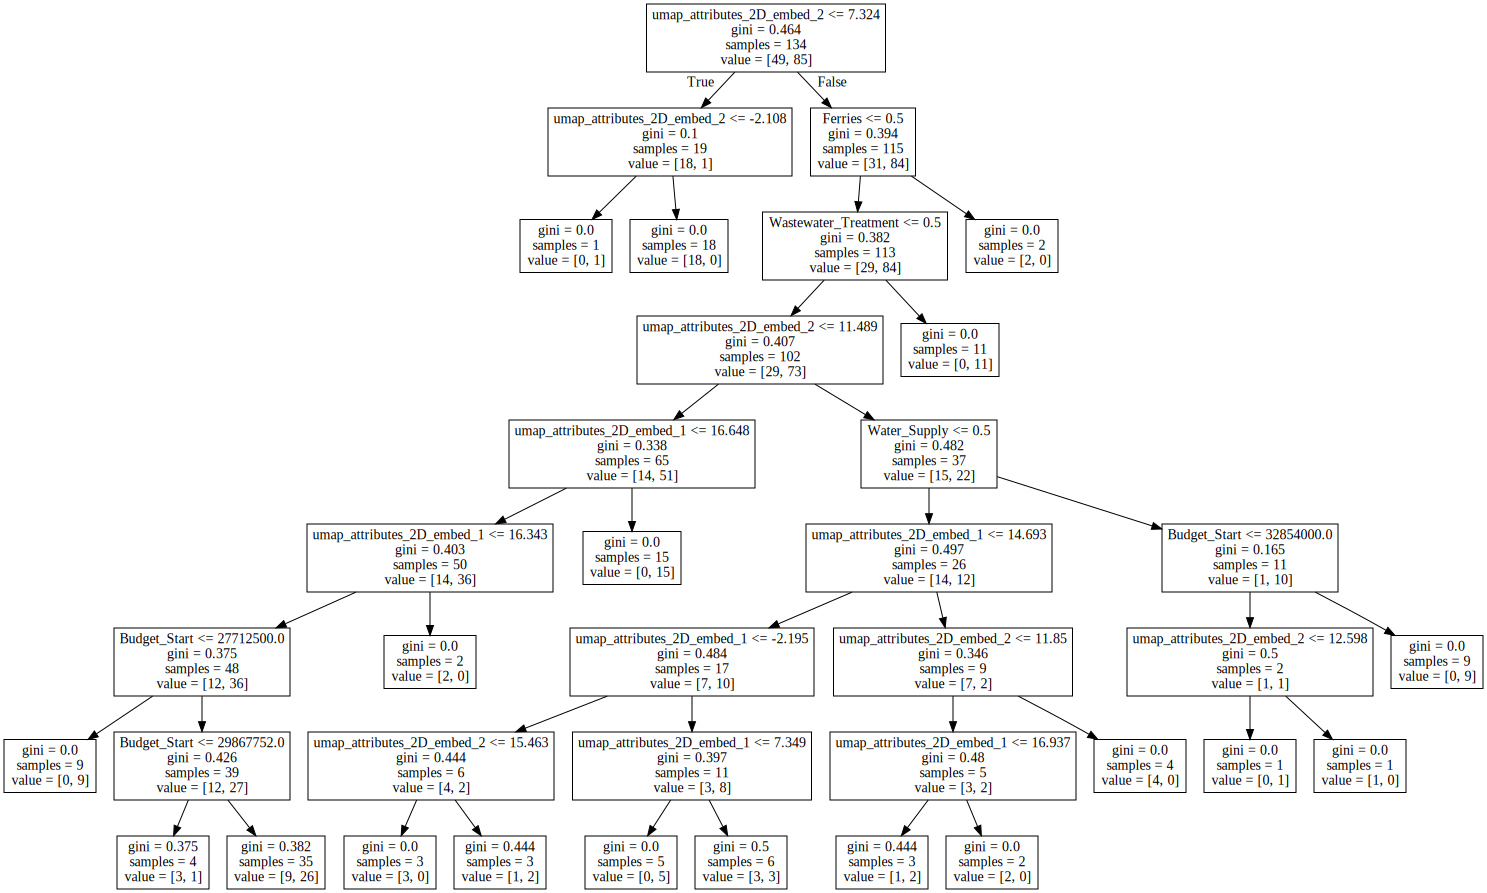

Model Optmized for: ['Schedule_Change_Ratio']


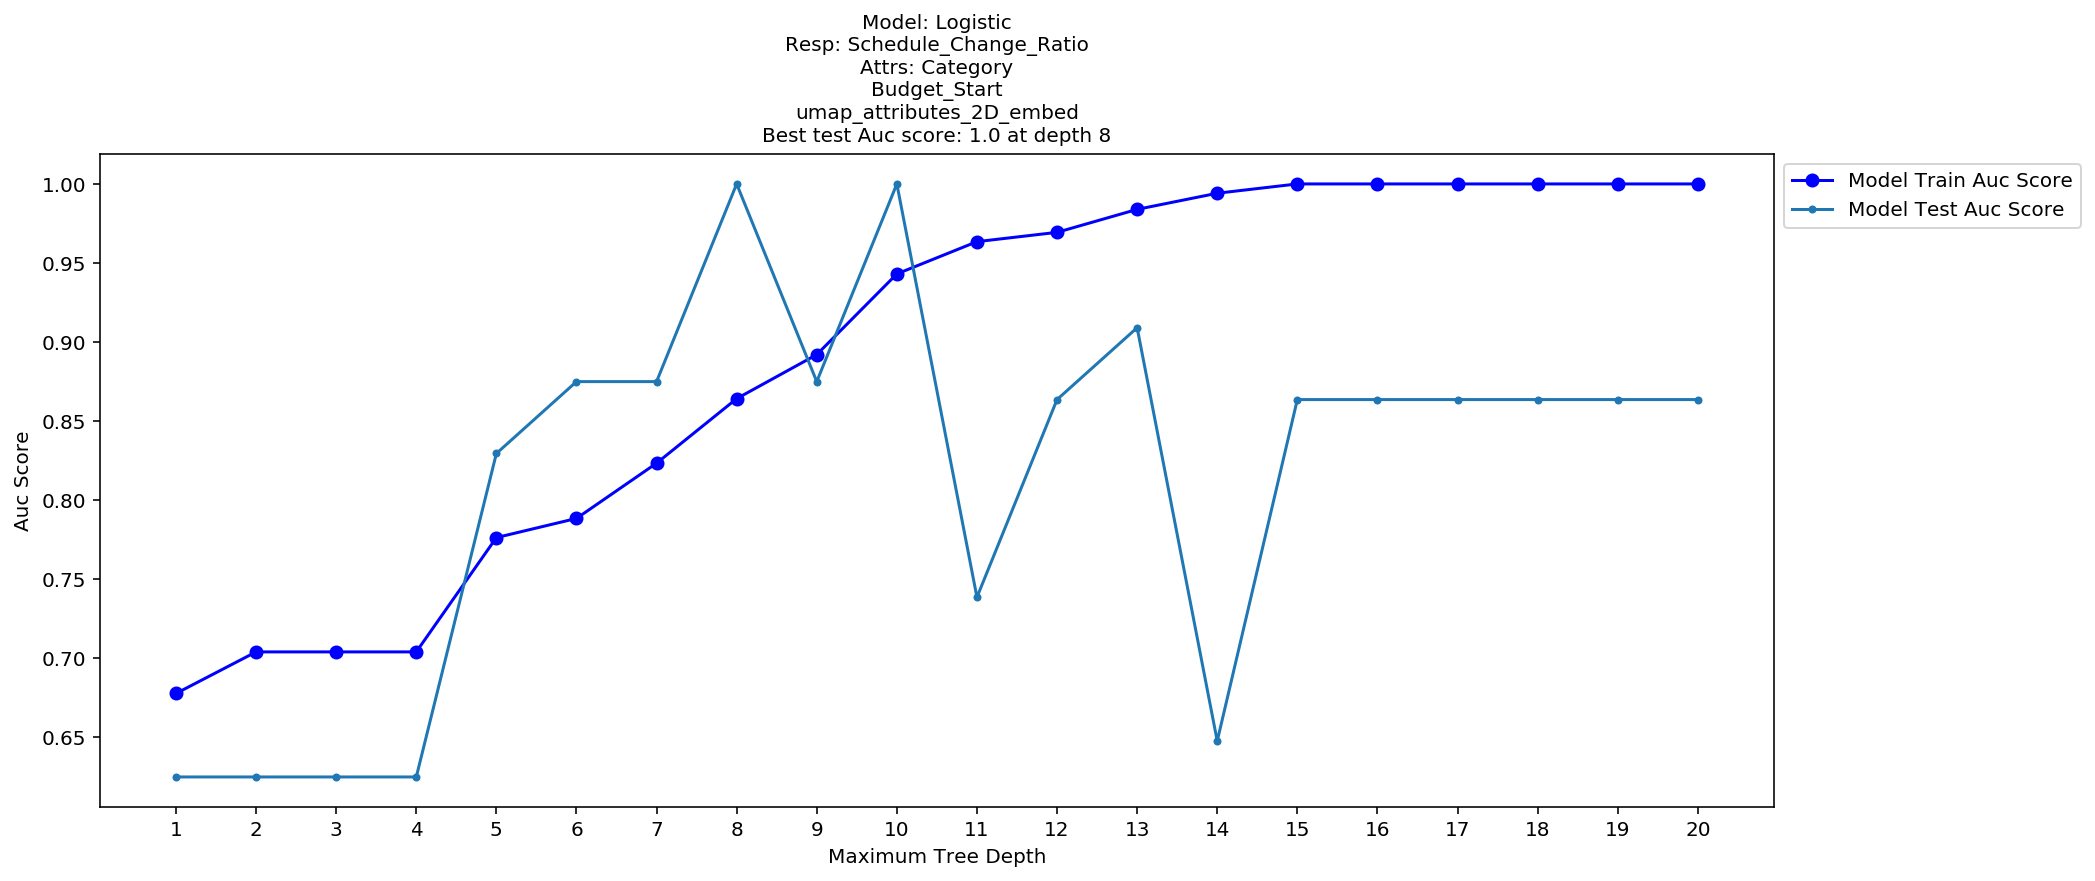

In [16]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

with open('../models/tree_classifier_schedule_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-classifier model predicting schedule_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

### Review Best Performing Model with 'Budget Change' Response


Index Chosen: 54
Best auc Score of Model Chosen: 0.75 // Depth: 11
Model Attributes: ['Category', 'umap_attributes_2D_embed', 'pca_descr_embed']
Model Response: ['Budget_Change_Ratio']


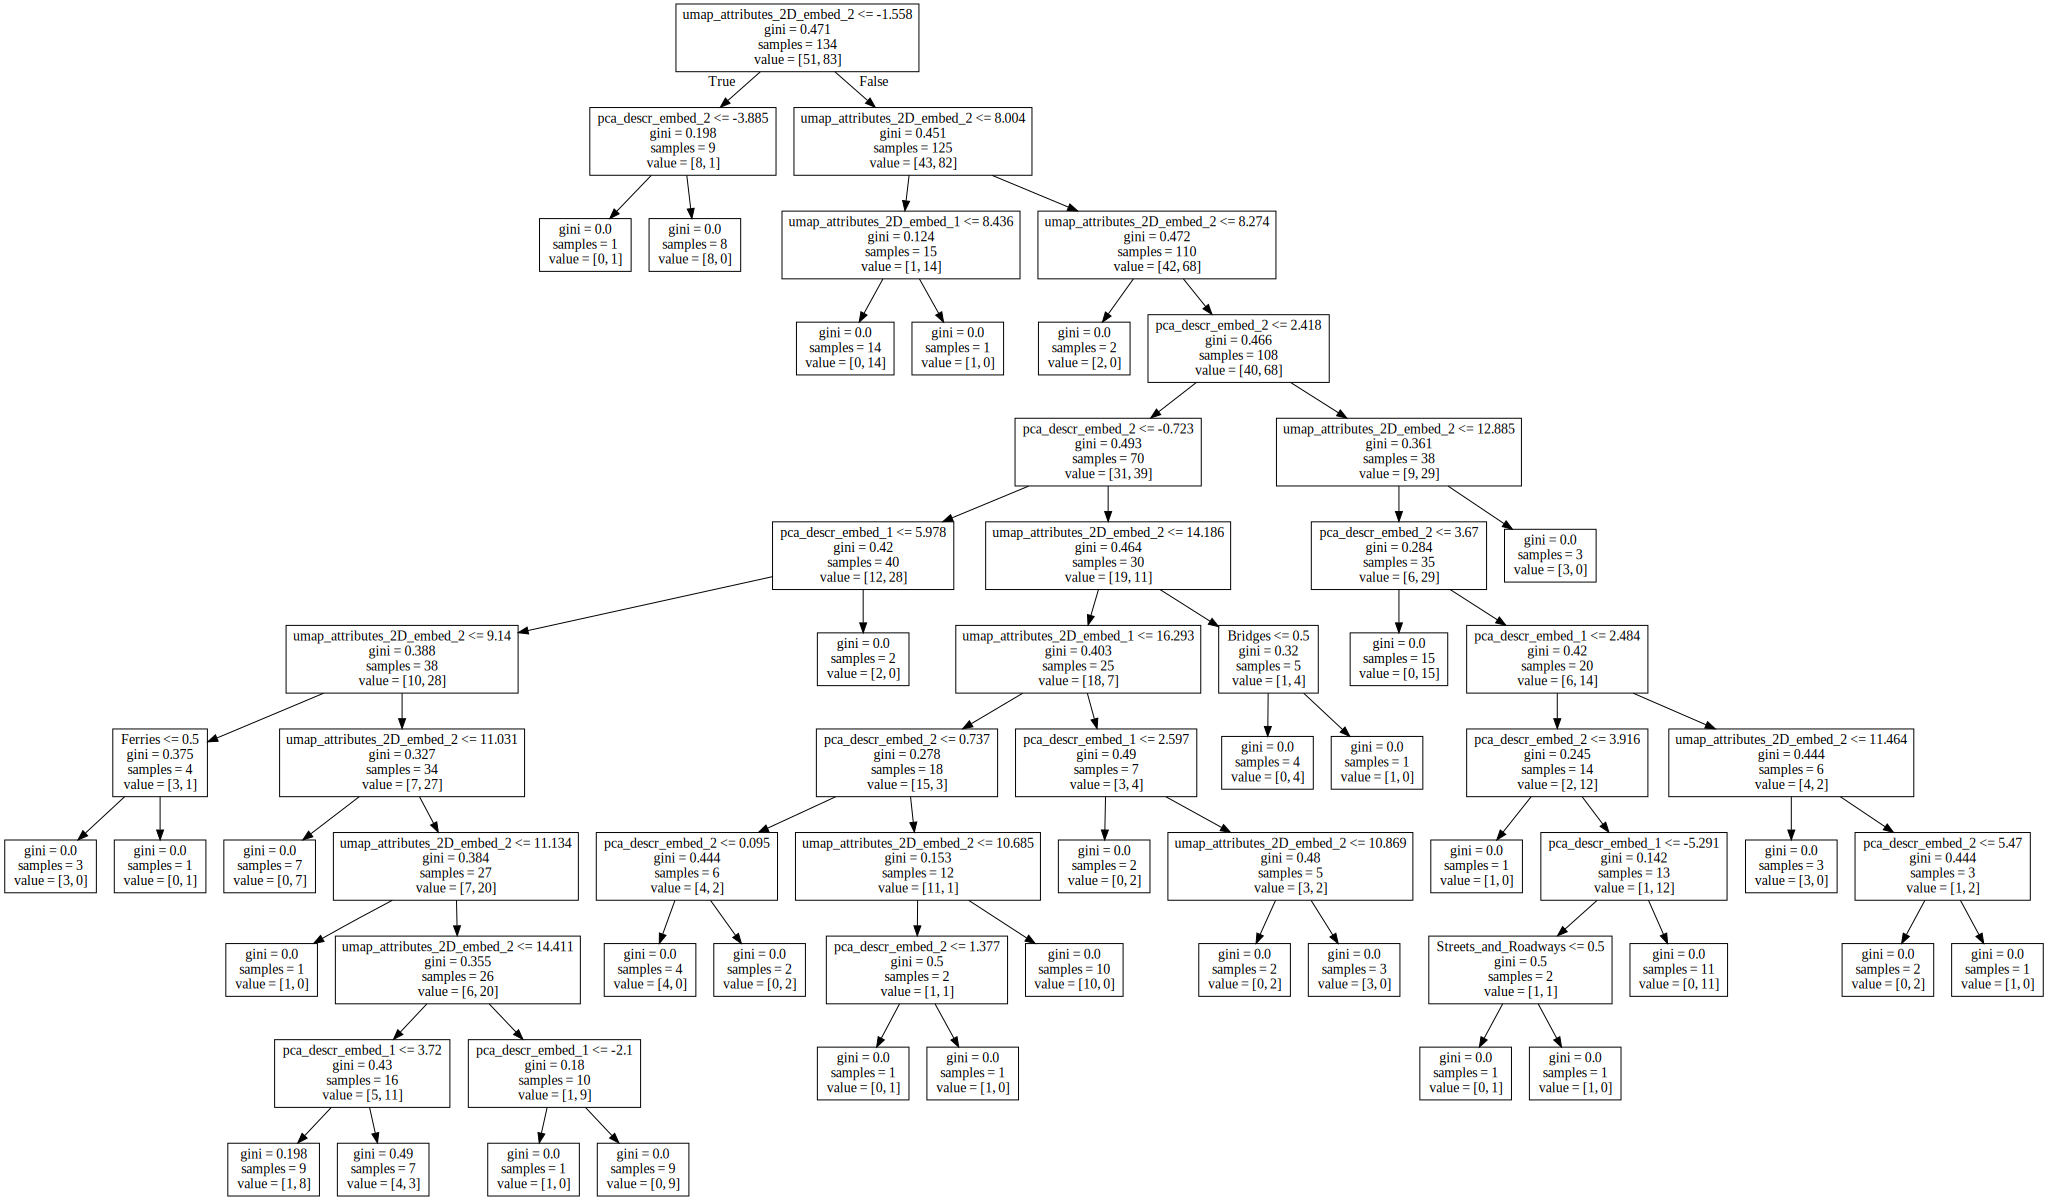

Model Optmized for: ['Budget_Change_Ratio']


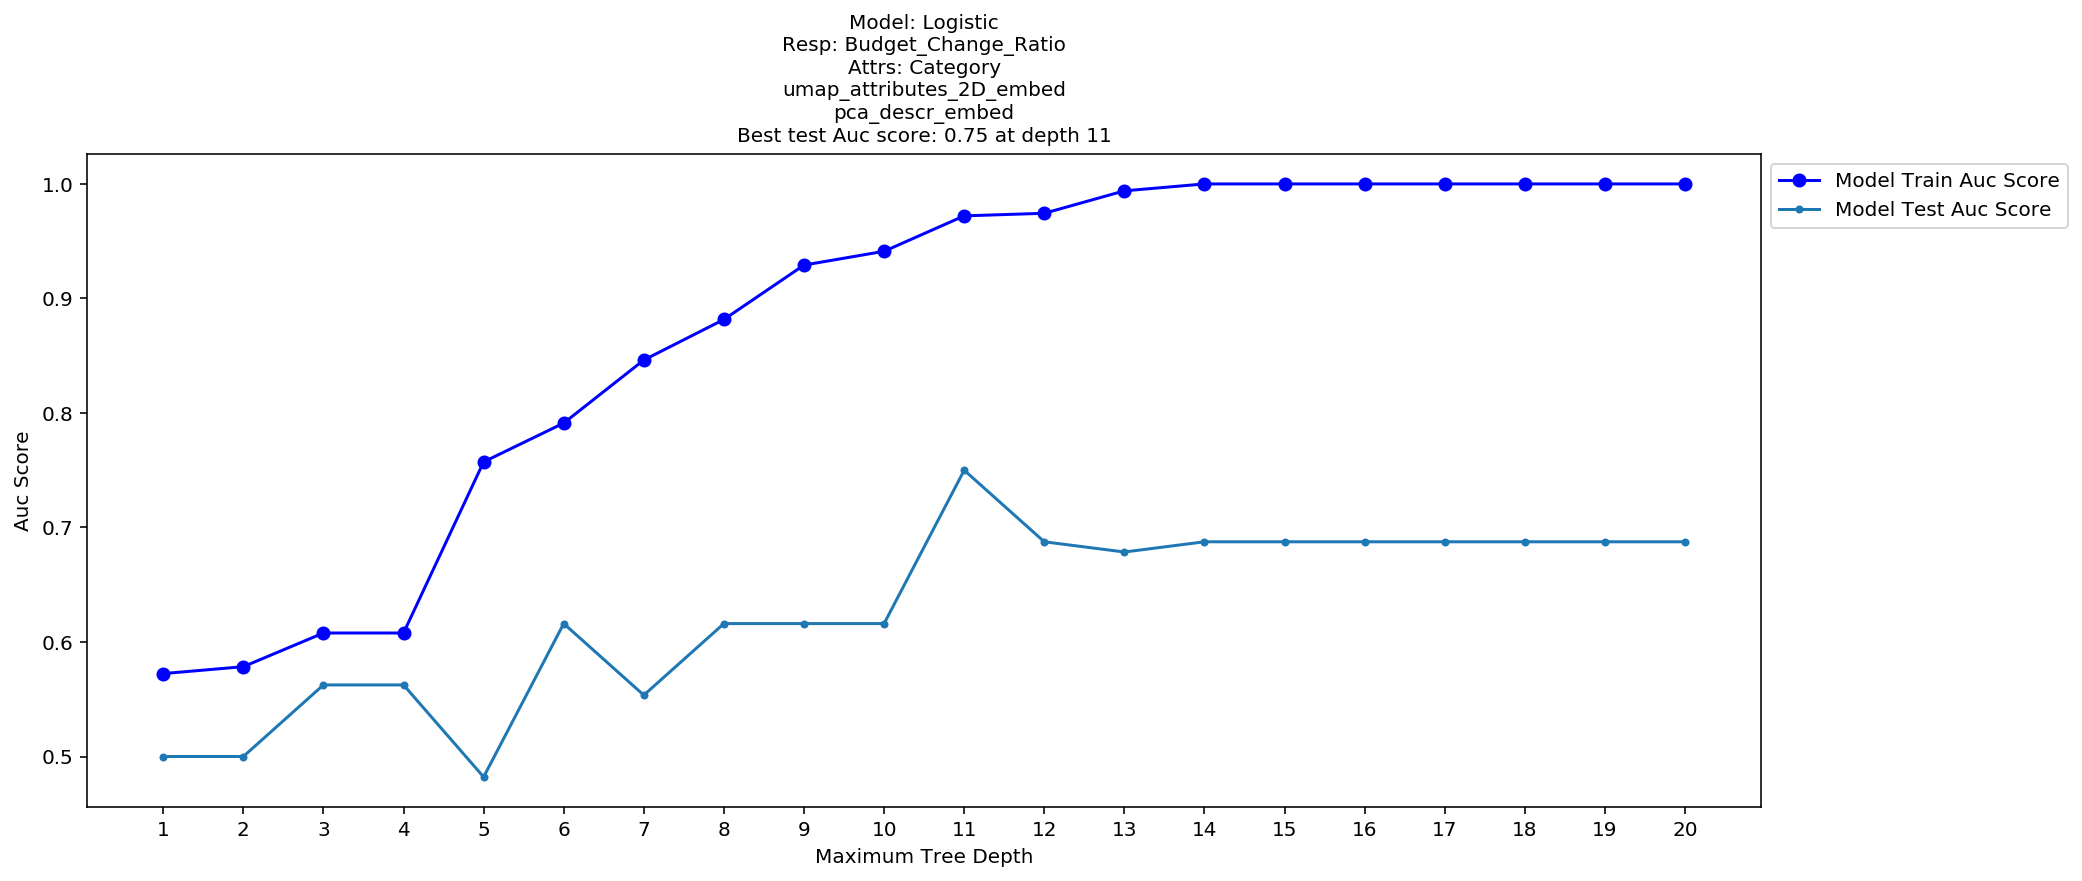

In [17]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

with open('../models/tree_classifier_budget_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-classifier model predicting budget_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

## Logsitic Models
These models will only try to predict if the budget or schedule will be over or under the initial estimate after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :
'Category', 'Budget_Start', 'umap_attributes_2D_embed'

Best depth: 8
Best AUC score: 1.0
Of note is that attributes using the project description embeddeding did not find the optimal model.
Also interestingis that the starting planned schedule is not used to find the outcome of the Schedule.

### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :
'Category', 'umap_attributes_2D_embed', 'pca_descr_embed'

Best depth: 11
Best AUC score: 0.75
Here, the description is inidicative the budget outcome.  Worth noting is the in the starting budget value is not useful in finding the optimal model to predict the budget outcome.


## Using Regression Models
The following steps will find the best combination of attributes to find the models which best predict Schedule and Budget.

In [18]:
nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=False)

Using REGRESSION models


In [19]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

,desc,model_type,attributes,full_attributes,responses,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_and_Schedule_Change,scoring,best_depth,train_score,train_scores,test_score,test_scores,best_model,depths
105,Regression Tree. Depth: 7,Regression,"[Budget_Start, Duration_Start, umap_attributes...","[Budget_Start, Duration_Start, umap_attributes...",[Schedule_Change_Ratio],0,1,0,r2,7,0.92,"[0.44471966298379717, 0.5113941010455046, 0.63...",0.71,"[0.3952918025270771, 0.4537588972378642, 0.537...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
79,Regression Tree. Depth: 7,Regression,"[Duration_Start, umap_attributes_2D_embed, pca...","[Duration_Start, umap_attributes_2D_embed_1, u...",[Schedule_Change_Ratio],0,1,0,r2,7,0.94,"[0.44471966298379717, 0.5113941010455046, 0.64...",0.68,"[0.3952918025270771, 0.45375889723786433, 0.56...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
99,Regression Tree. Depth: 3,Regression,"[Category, Duration_Start, umap_attributes_2D_...","[Duration_Start, Bridges, Ferries, Industrial_...",[Schedule_Change_Ratio],0,1,0,r2,3,0.64,"[0.44471966298379717, 0.5113941010455046, 0.64...",0.66,"[0.3952918025270771, 0.4537588972378642, 0.656...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 105
Model Optmized for: ['Schedule_Change_Ratio']
Best r2 Score of Model Chosen: 0.7077 // Depth: 7
Model Attributes: ['Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
Model Response: ['Schedule_Change_Ratio']


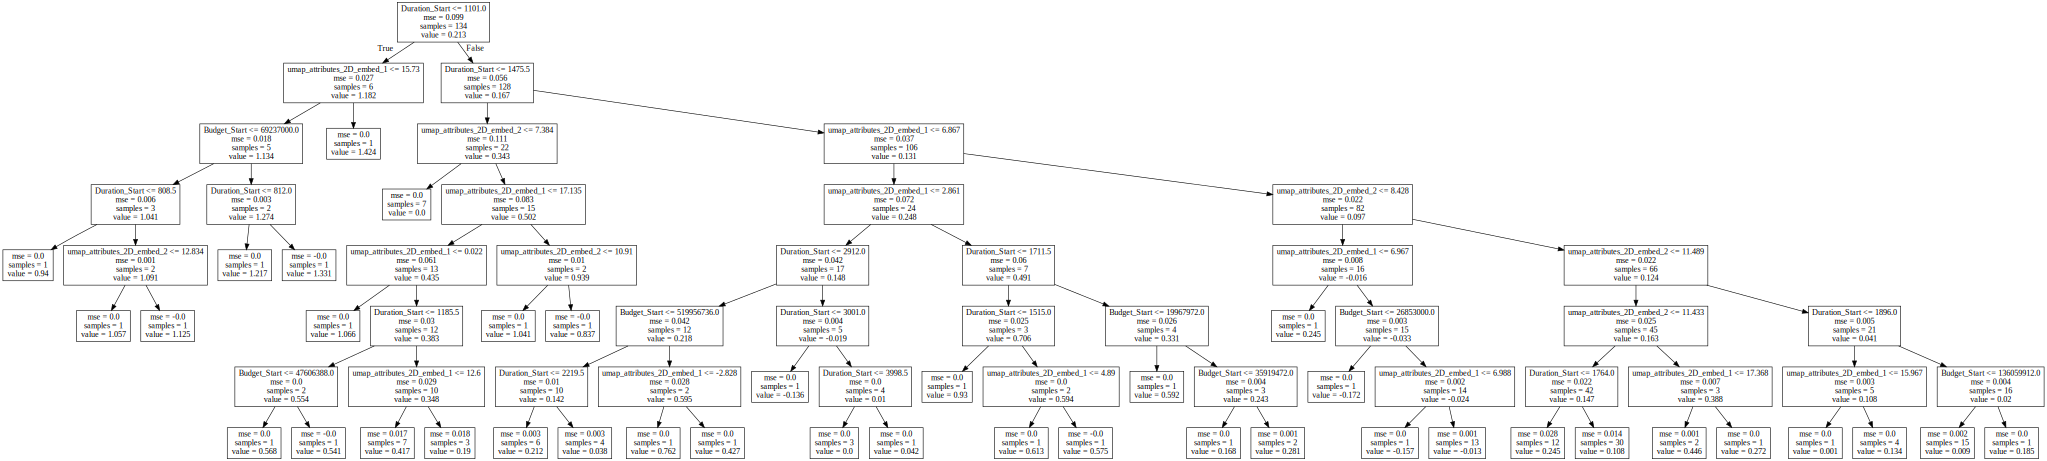


MODEL SUMMARY:
Regression Tree. Depth: 7


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9968
		Test		-0.1285

	Schedule_Chang

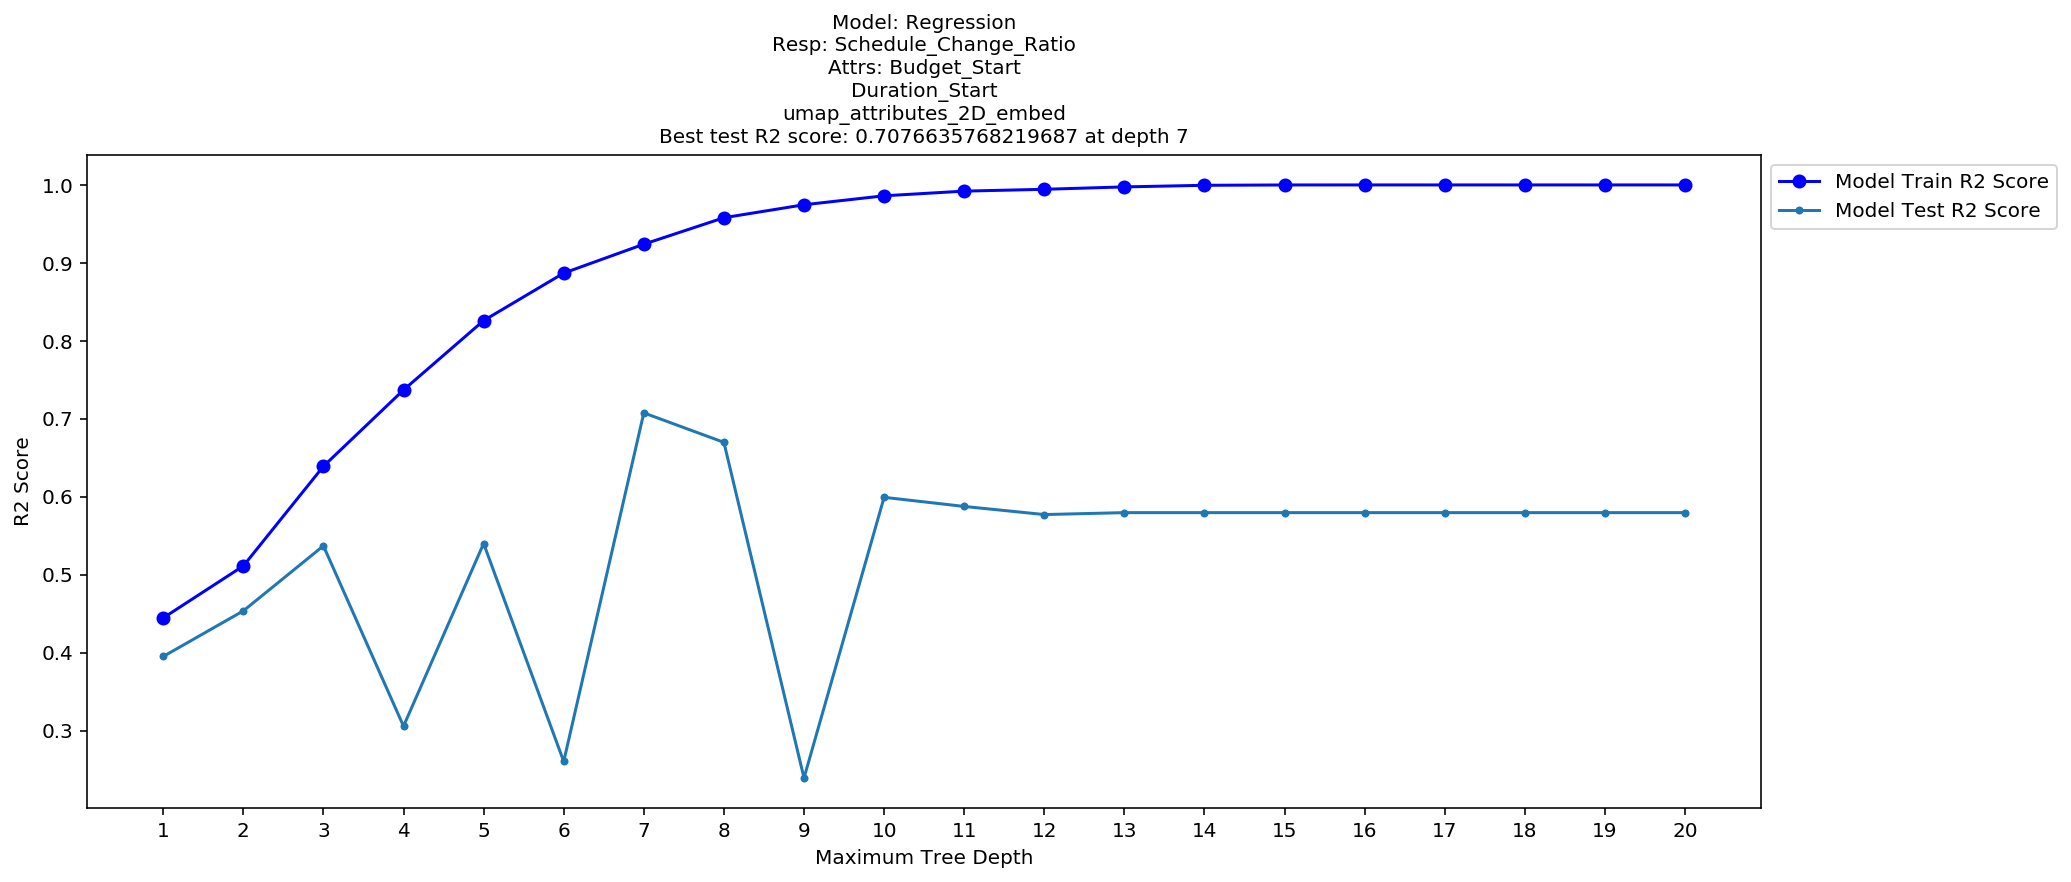

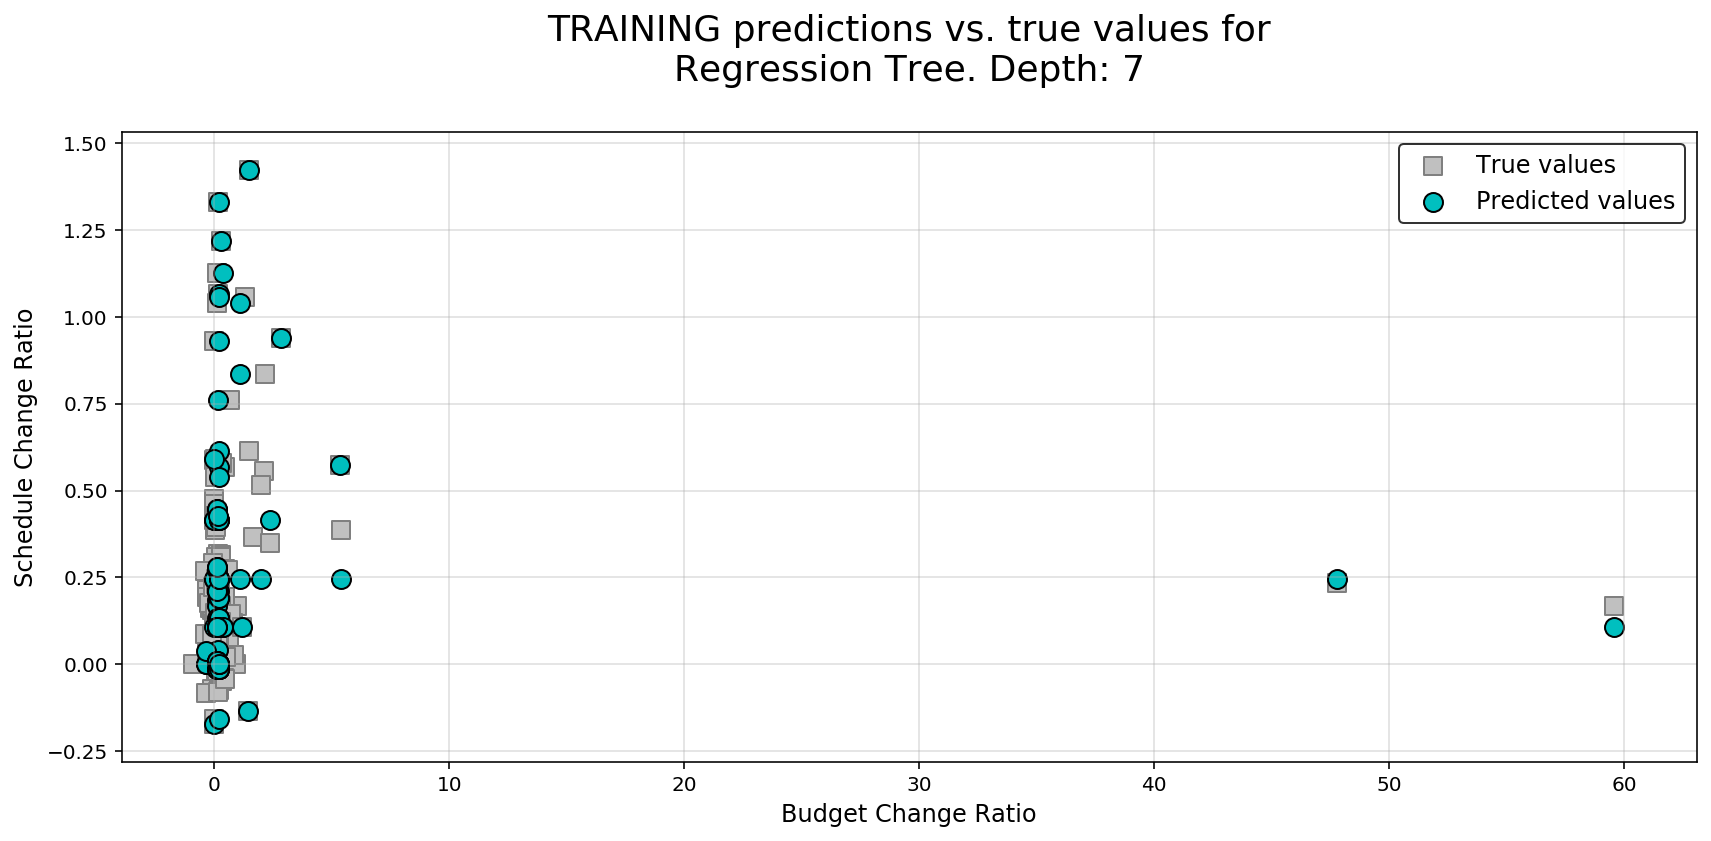

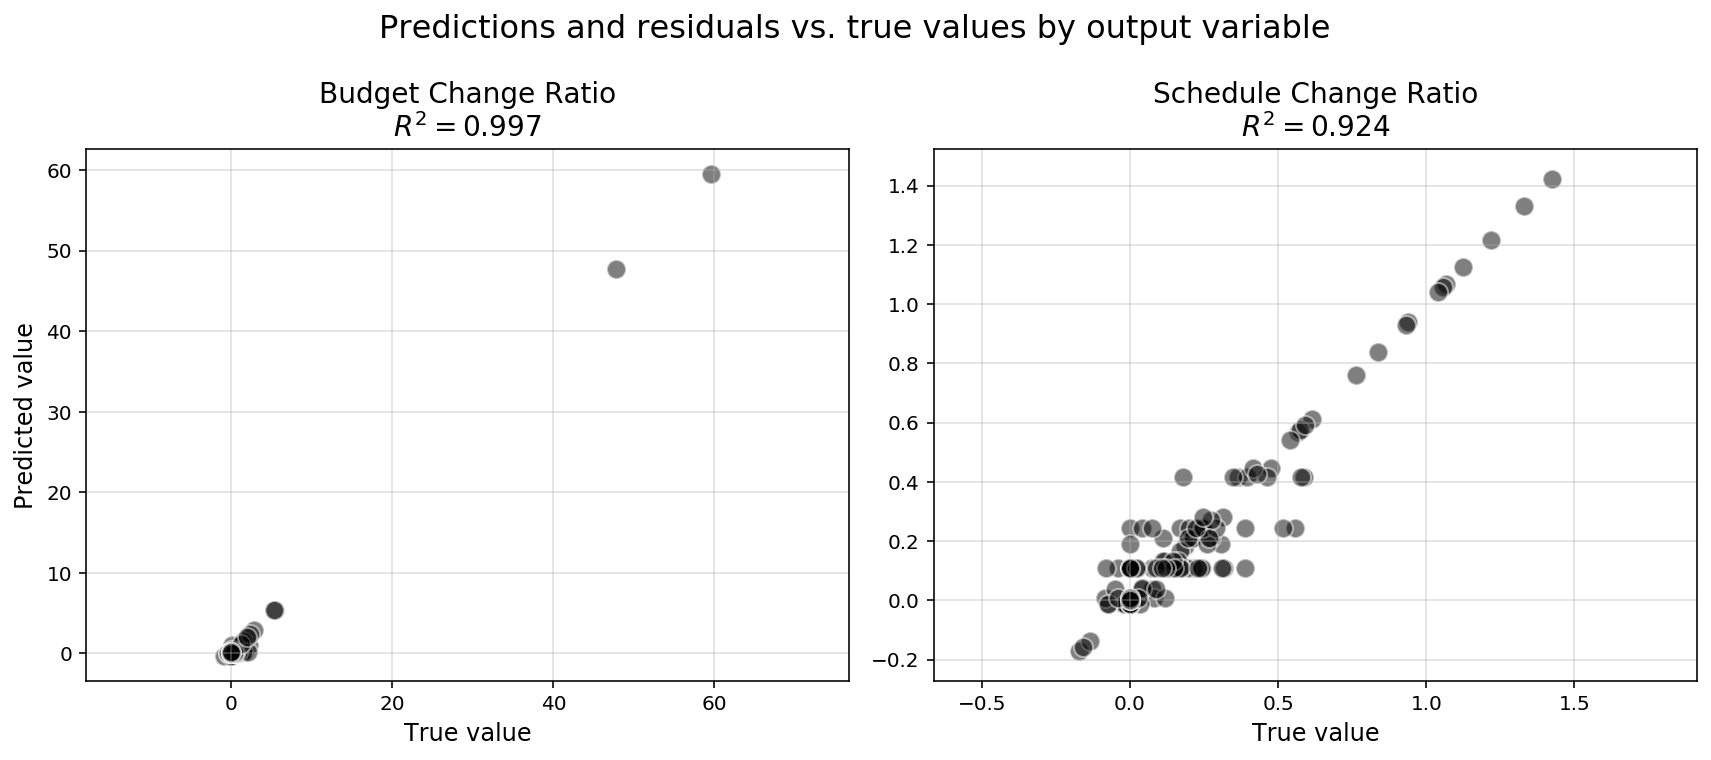

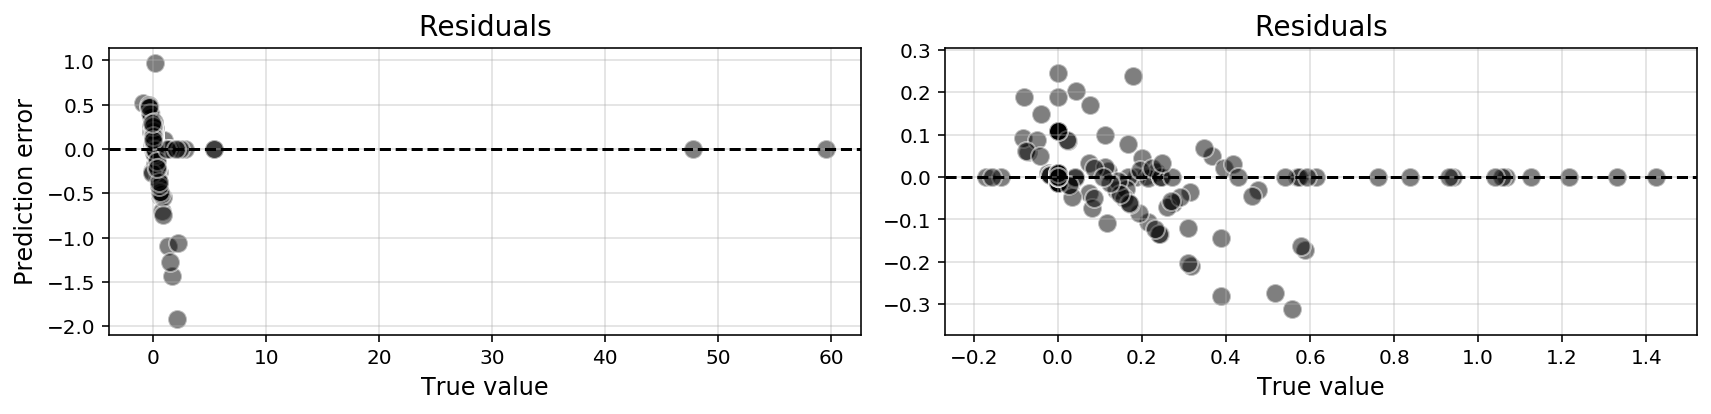

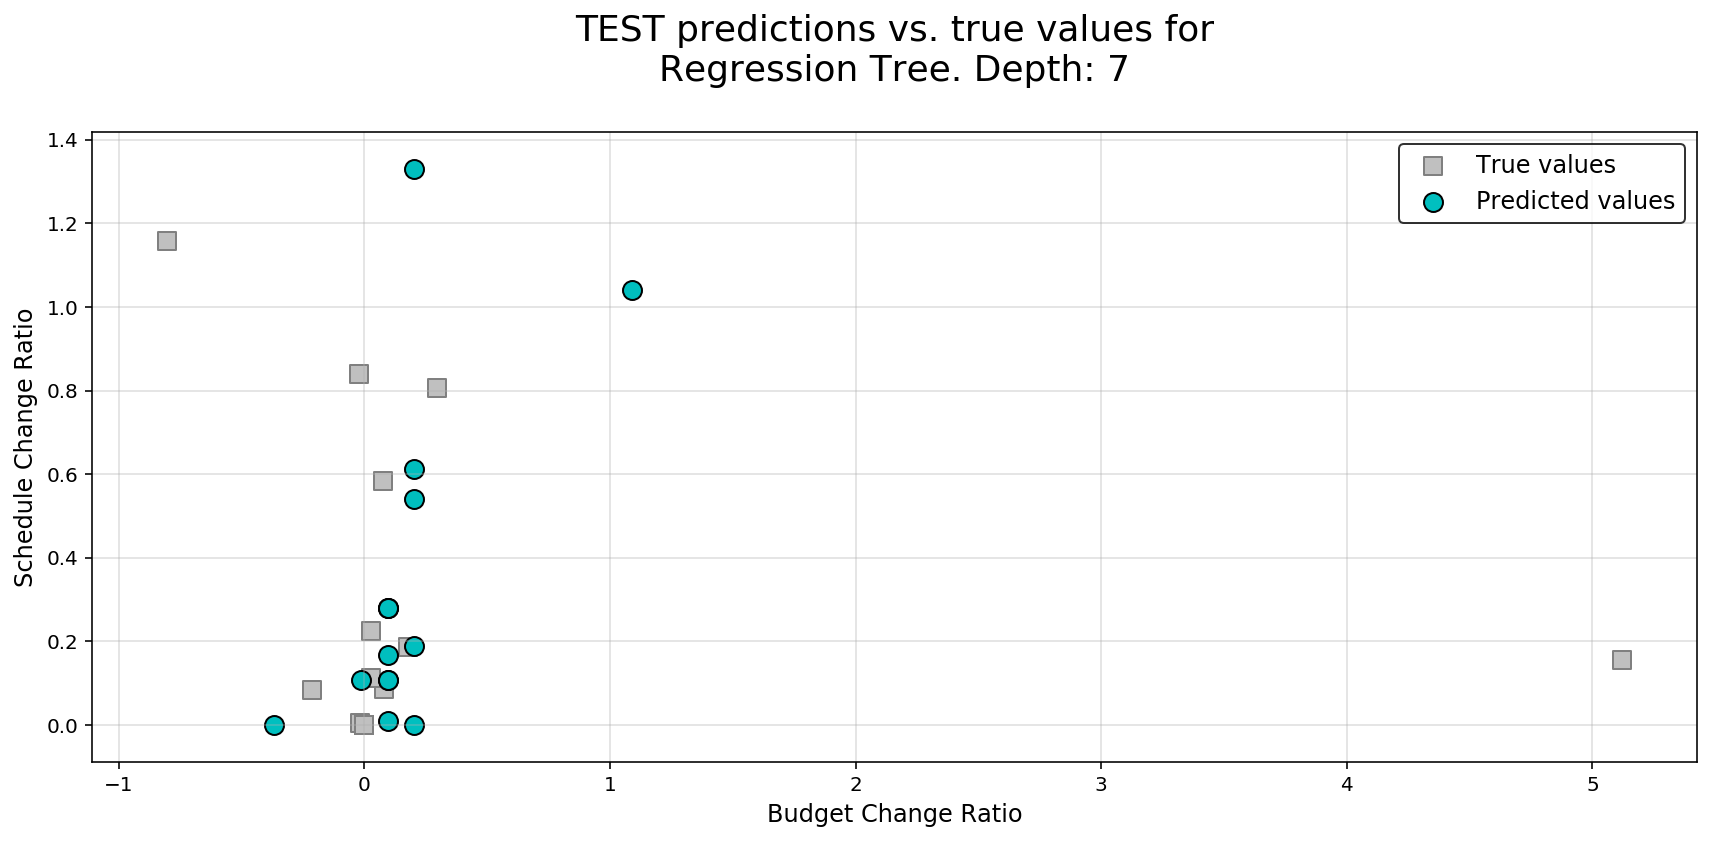

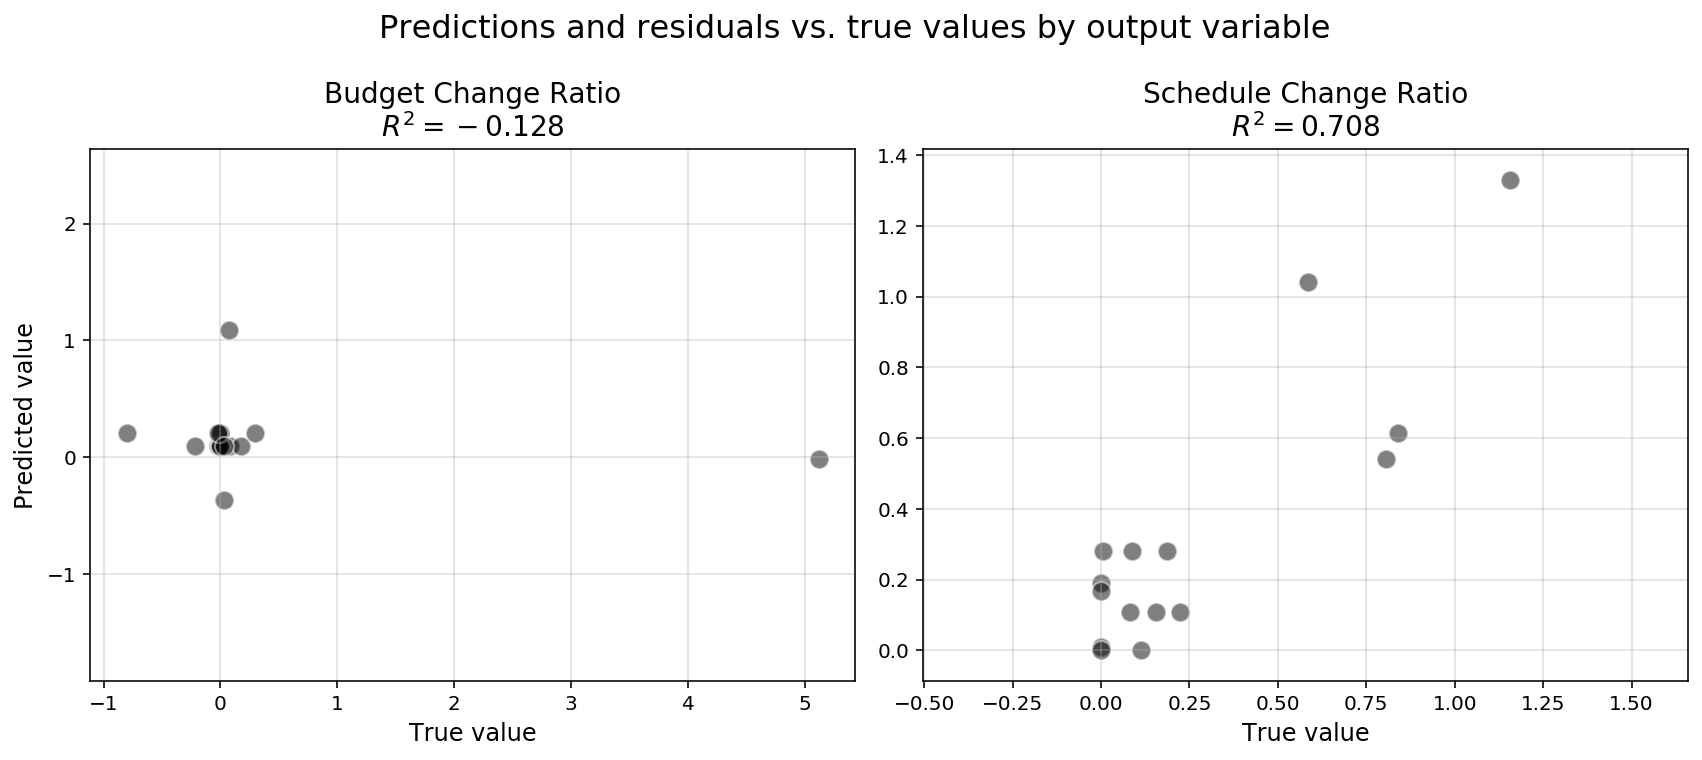

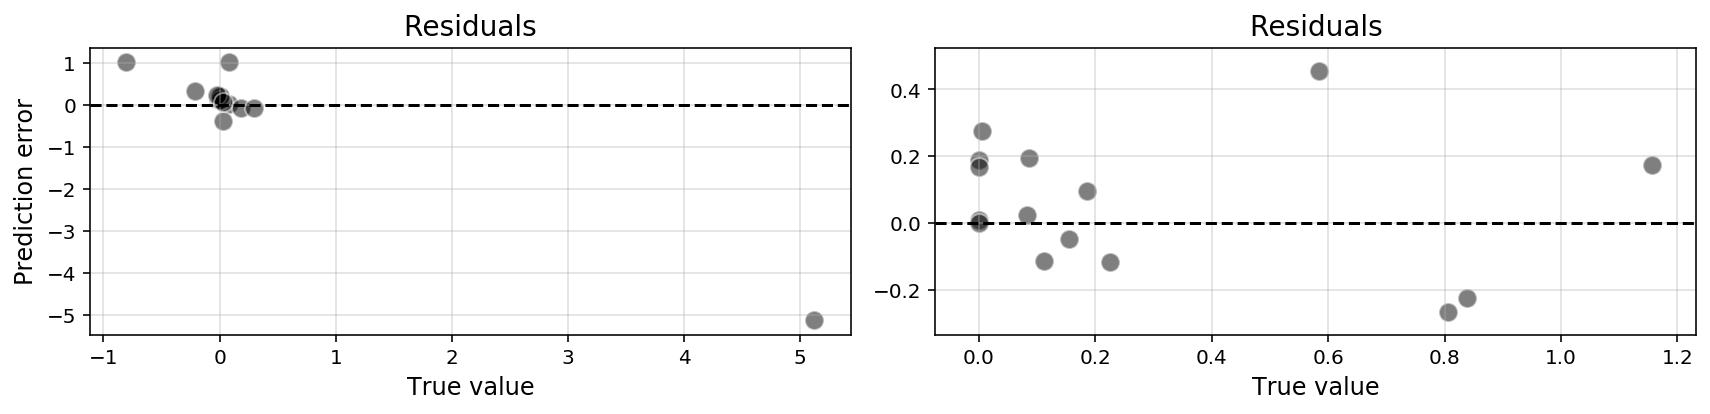

In [20]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

with open('../models/tree_regressor_schedule_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-regressor model predicting schedule_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

Index Chosen: 8
Model Optmized for: ['Budget_Change_Ratio']
Best r2 Score of Model Chosen: 0.3588 // Depth: 6
Model Attributes: ['Budget_Start']
Model Response: ['Budget_Change_Ratio']


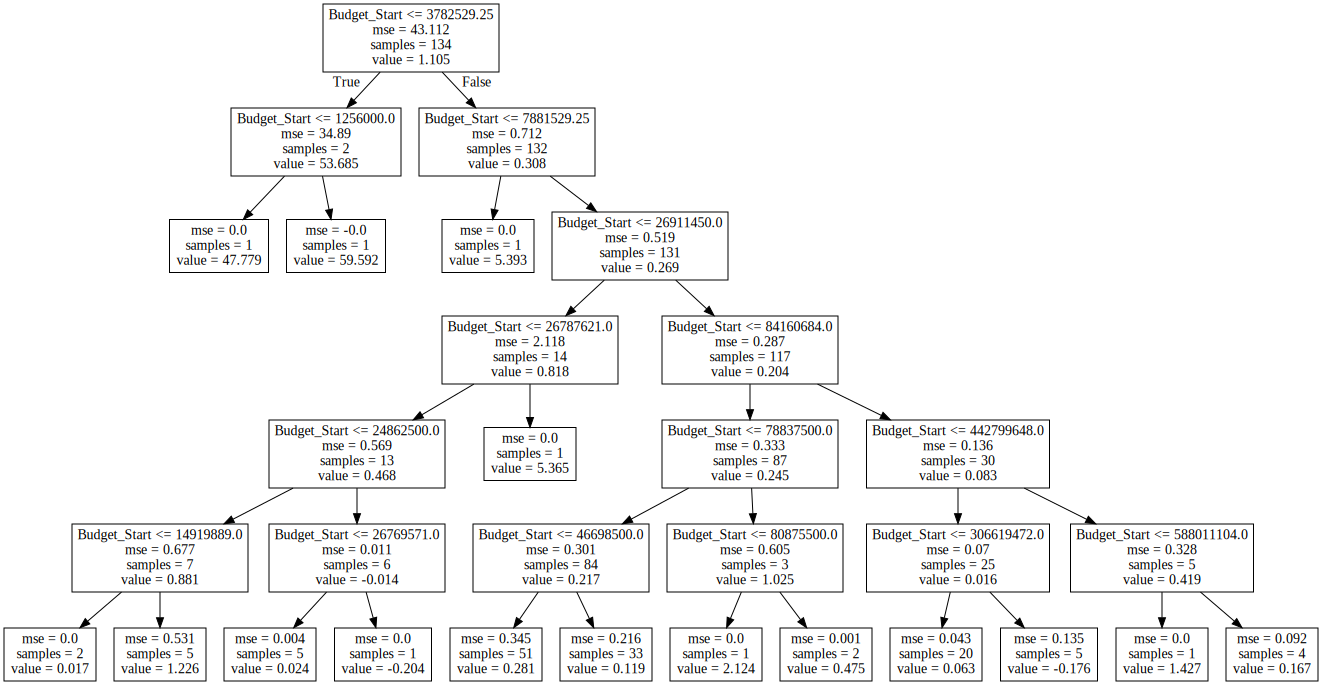


MODEL SUMMARY:
Regression Tree. Depth: 6


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9949
		Test		0.3588

	Schedule_Change

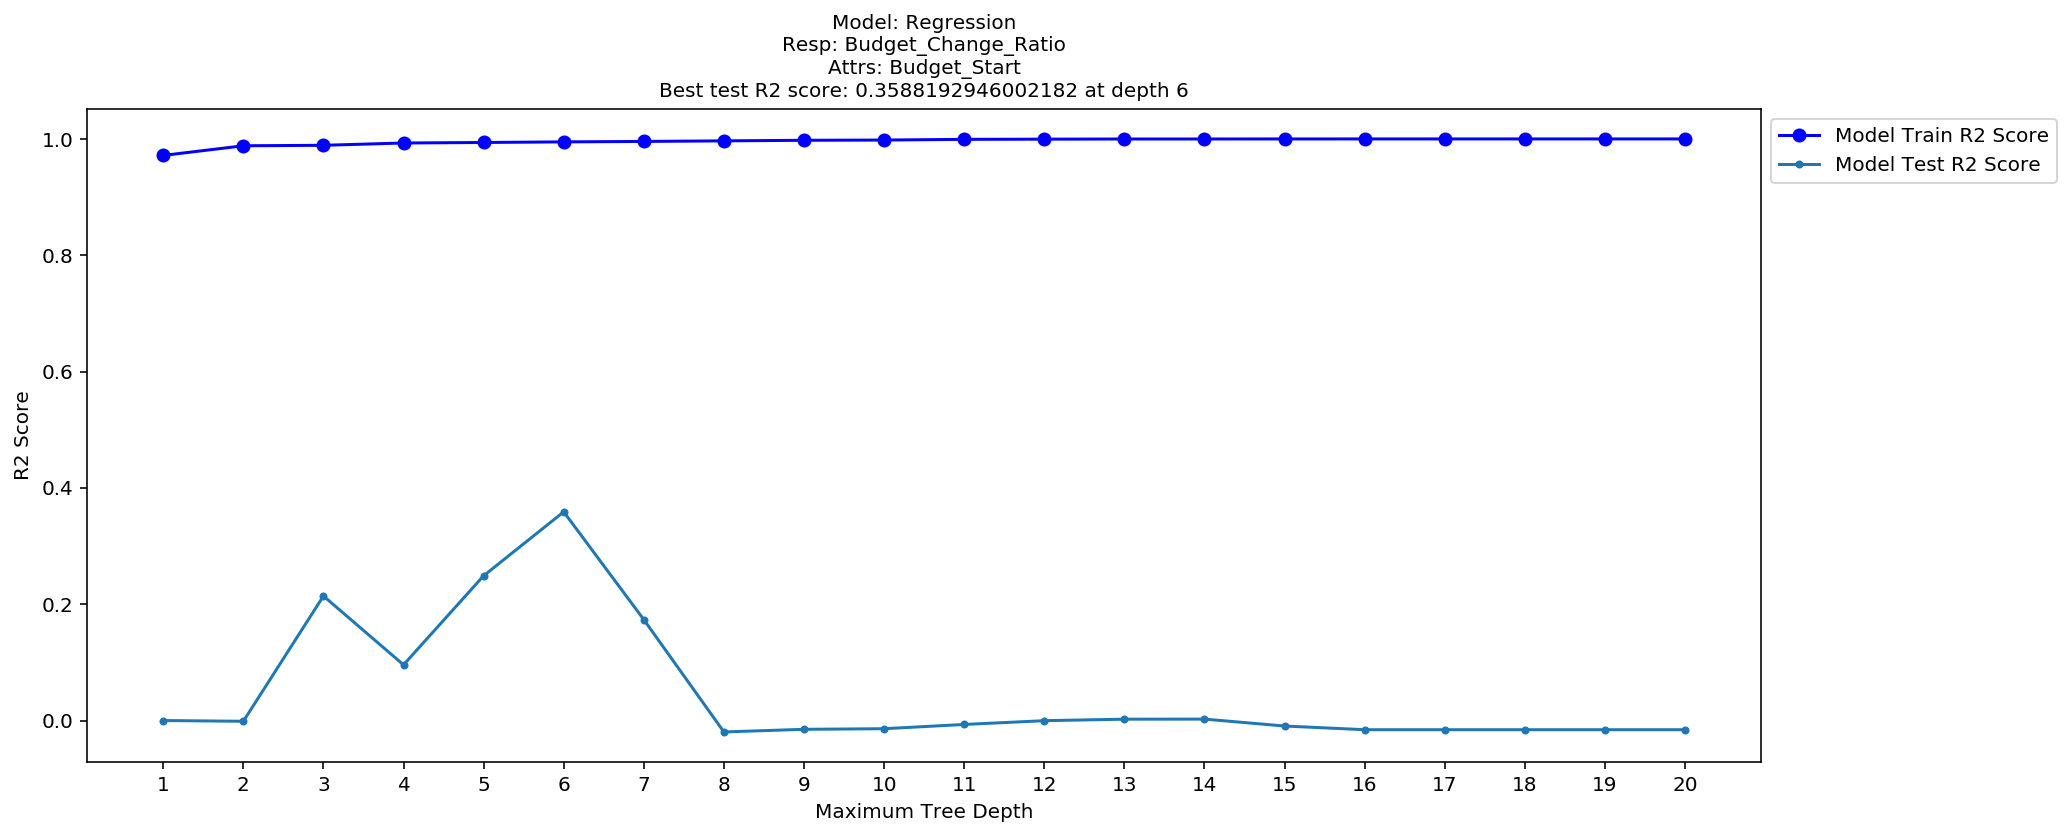

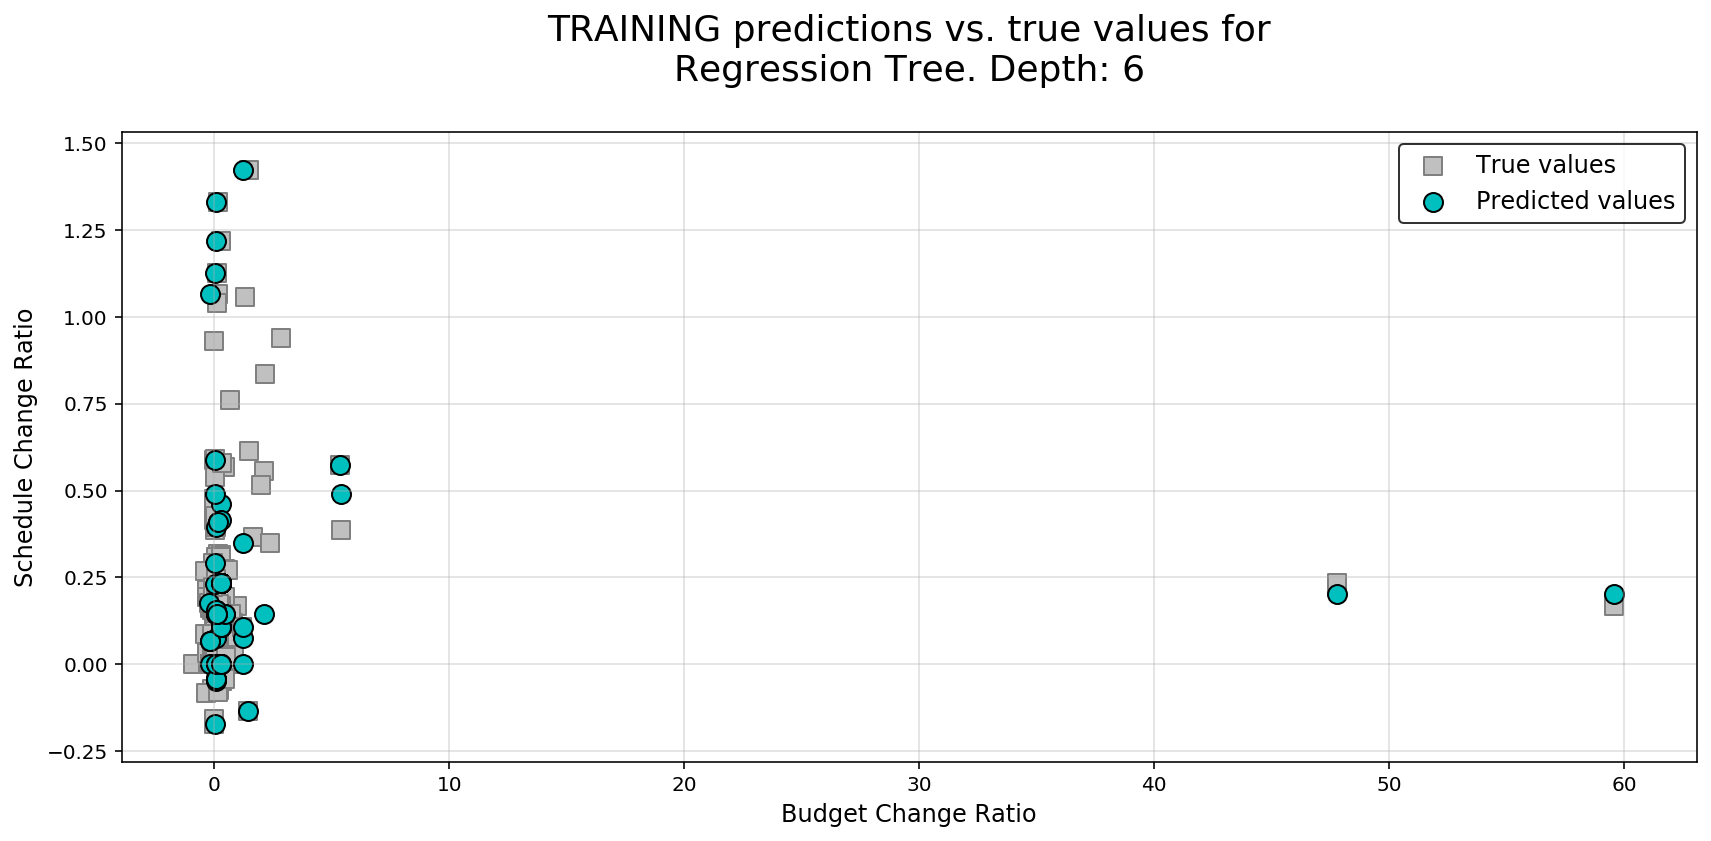

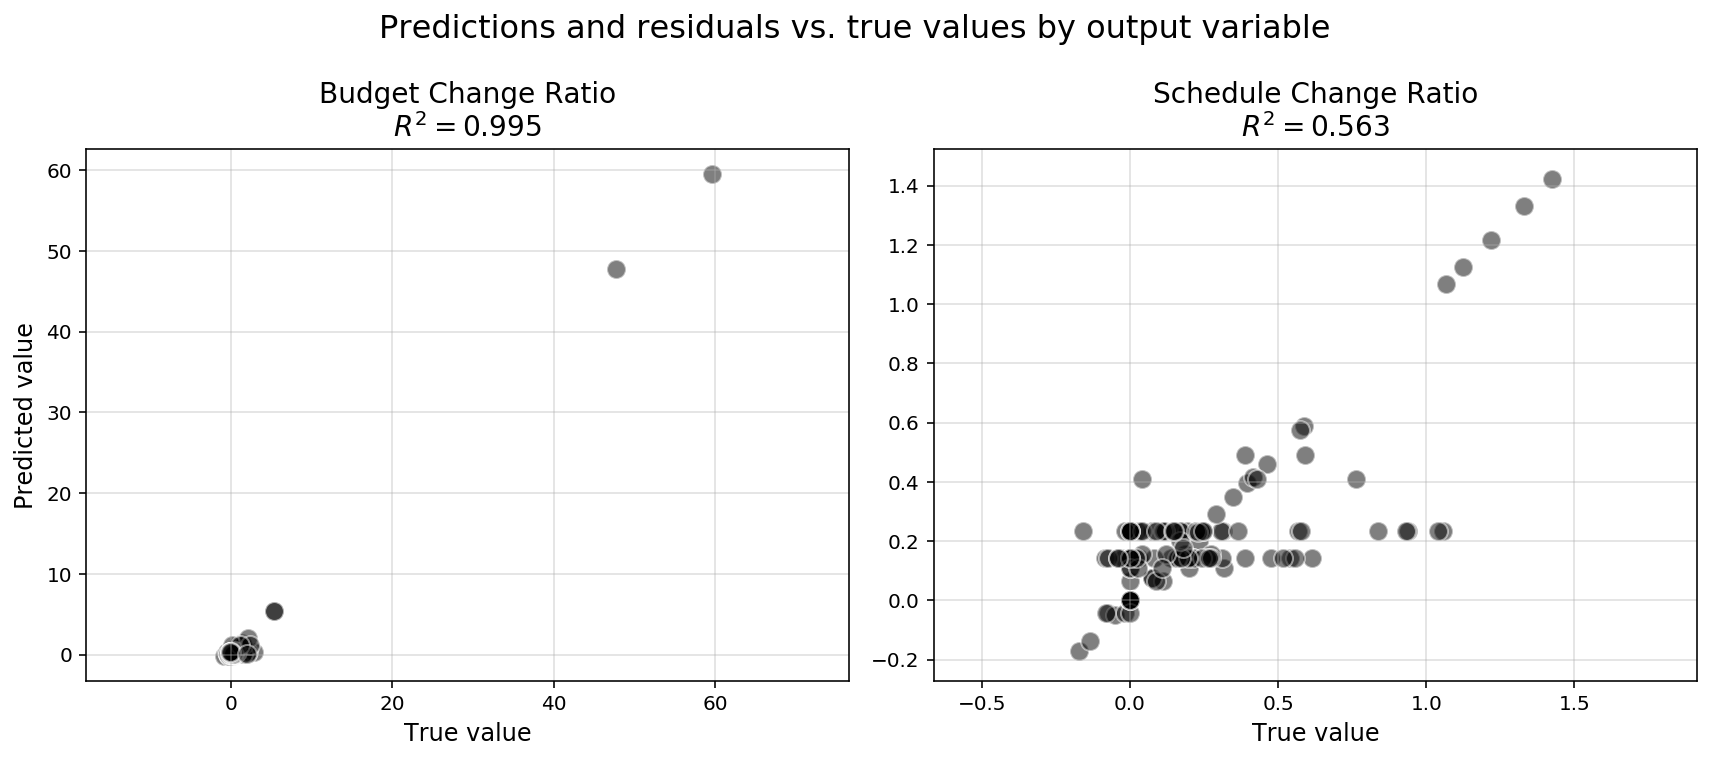

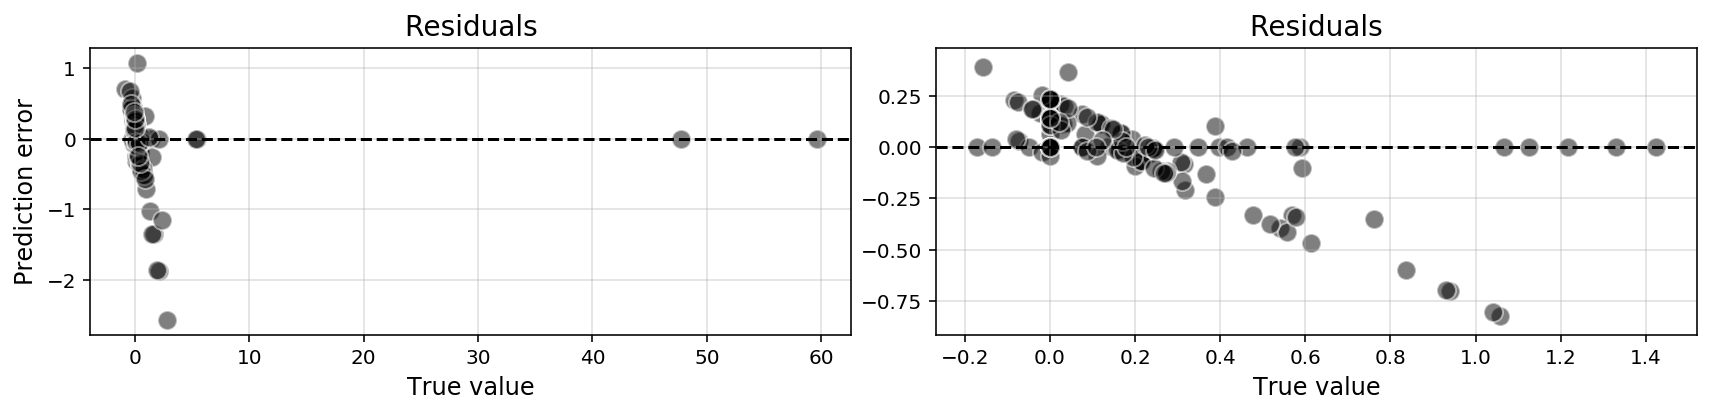

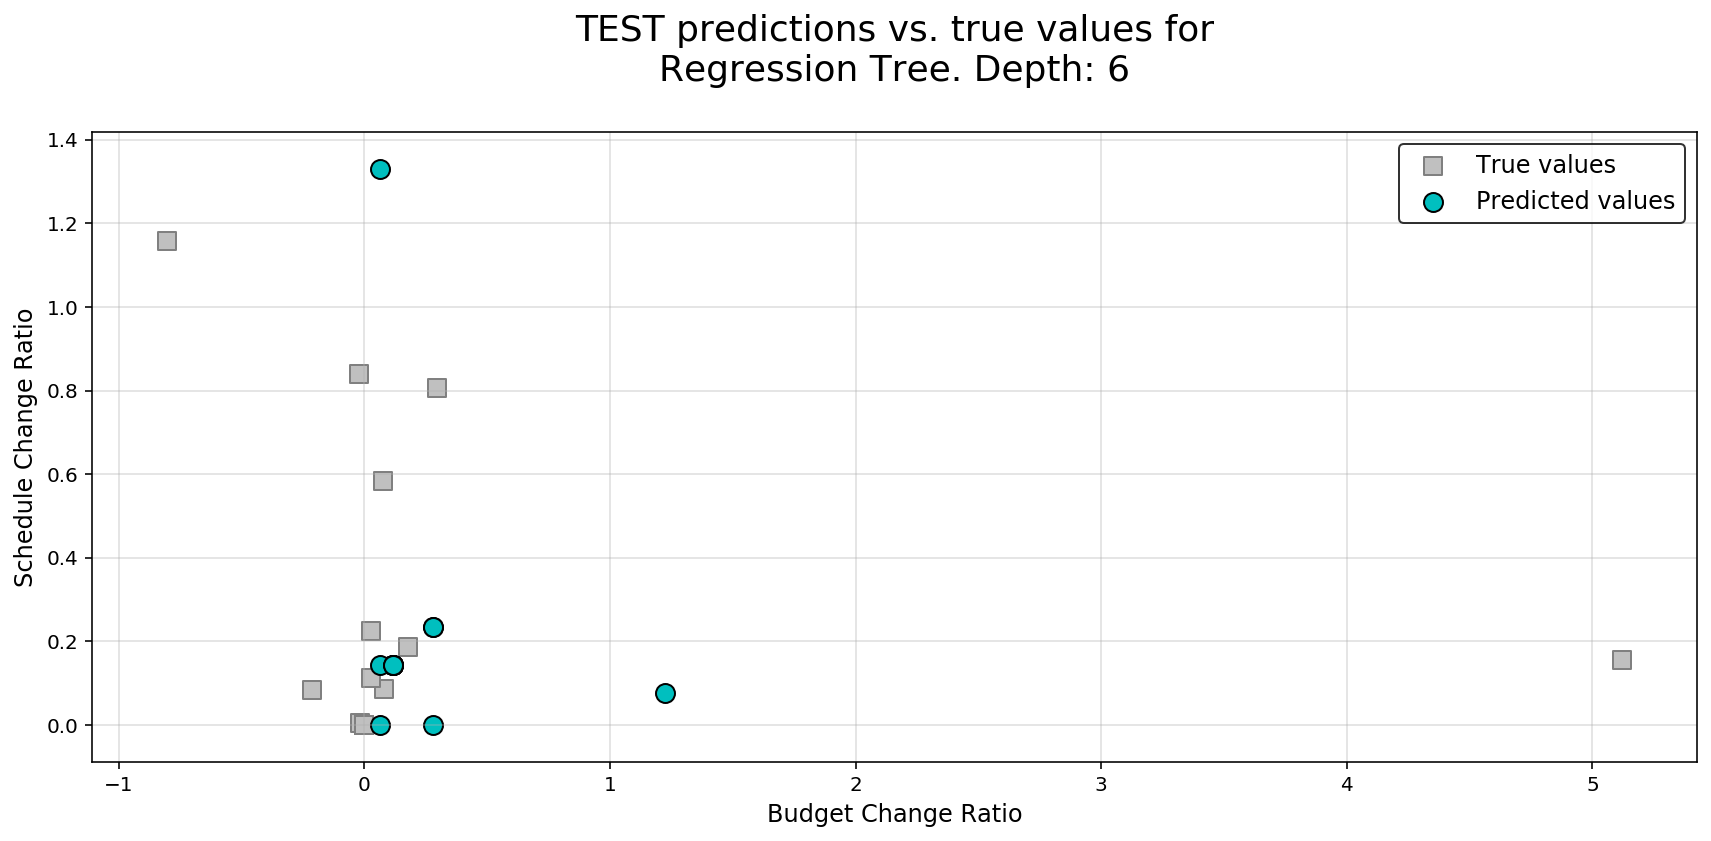

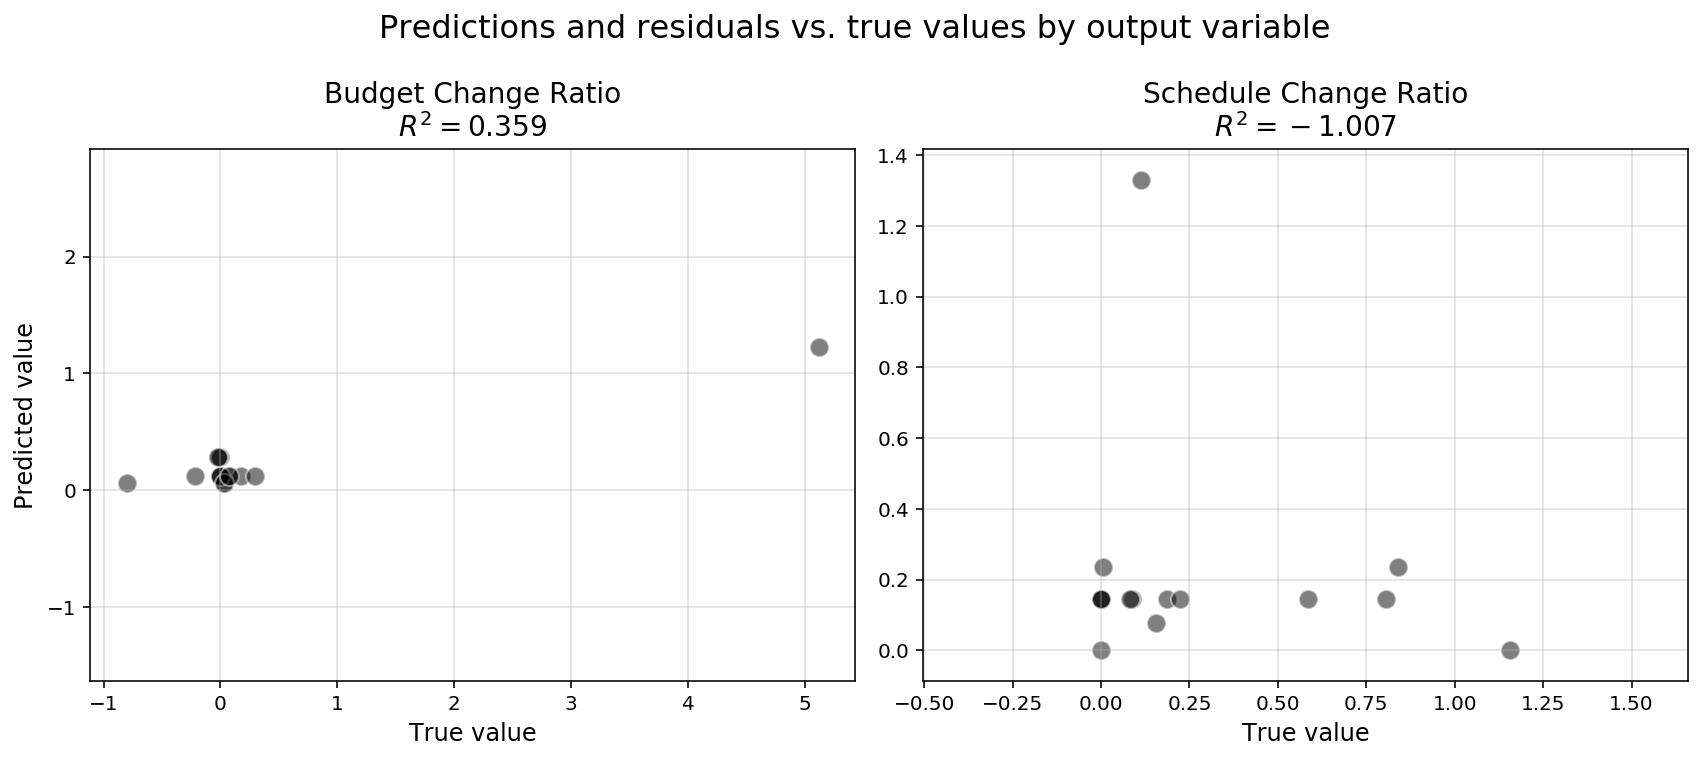

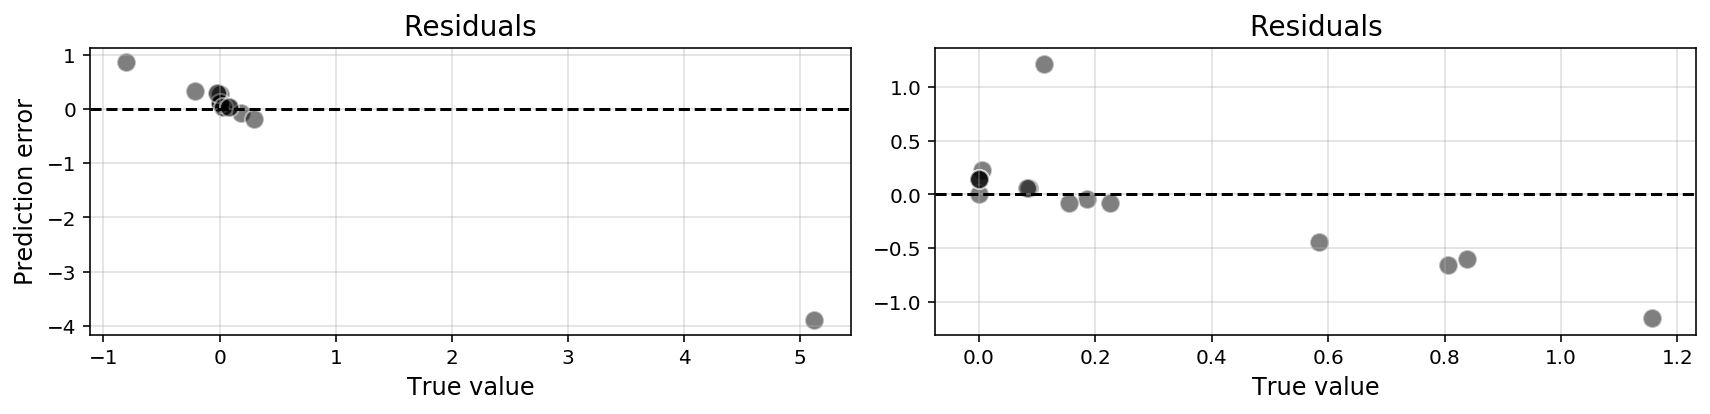

In [21]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

with open('../models/tree_regressor_budget_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-regressor model predicting budget_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

## Regression Models
These models attempt to predict the ending Schedule and Budget values after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :
Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed'

Best depth: 7
Best R2 score: 0.7077
Of note is that attributes using the project description embeddeding did not find the optimal model.

### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :
'Budget_Start'

Best depth: 6
Best R2 score: .3588
Here, only the starting budget value is determined to be significant when predicting 'Budget Change Ratio'.  The R3 score is not exceptionally impressive which may be the result of some extreme outliers in the data.
